In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/target/train_target.csv
/kaggle/input/feature-engineering/processed_chunk_000.parquet
/kaggle/input/feature-engineering/processed_chunk_008.parquet
/kaggle/input/feature-engineering/processed_chunk_004.parquet
/kaggle/input/feature-engineering/x_test.parquet
/kaggle/input/feature-engineering/y_test.csv
/kaggle/input/feature-engineering/y_train.csv
/kaggle/input/feature-engineering/test_fe.parquet
/kaggle/input/feature-engineering/__results__.html
/kaggle/input/feature-engineering/data.parquet
/kaggle/input/feature-engineering/x_train.parquet
/kaggle/input/feature-engineering/zero_features_it1.txt
/kaggle/input/feature-engineering/relevant_features.txt
/kaggle/input/feature-engineering/processed_chunk_007.parquet
/kaggle/input/feature-engineering/train_fe.parquet
/kaggle/input/feature-engineering/processed_chunk_003.parquet
/kaggle/input/feature-engineering/processed_chunk_001.parquet
/kaggle/input/feature-engineering/__notebook__.ipynb
/kaggle/input/feature-engineering/pr

In [2]:
import zipfile
import os
import csv
import gc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc, make_scorer, ConfusionMatrixDisplay, confusion_matrix, classification_report
import zipfile
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM 
from sklearn.ensemble import GradientBoostingClassifier,  HistGradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance
import torch

import torch.utils.data as data_utils
import torch.nn as nn

In [3]:
#К базовому набору признаков ДО агрегации добавим: 
#1.  флаг о том, что по продукту не было ни одной просрочки
#добавим в признаки флаг - по продукту не было ни одной просрочки
def count_zero_loans(data):
    zero_loans = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']
    data["no_delays"] =  data.loc[:, zero_loans].eq(1).sum(axis=1).apply(lambda x:1 if x==5 else 0)
    return data

In [4]:
#2. посчитаем количество статусов платежей по продукту за все время 

def count_enc_payments_status(data):
    features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 
            'enc_paym_23', 'enc_paym_24']
    
    data["enc_paym_value0"] =  data.loc[:, features_paym].eq(0).sum(axis=1)
    data['enc_paym_value1'] =  data.loc[:, features_paym].eq(1).sum(axis=1)
    data['enc_paym_value2'] =  data.loc[:, features_paym].eq(2).sum(axis=1)
    data['enc_paym_value3'] =  df.loc[:, features_paym].eq(3).sum(axis=1)
  
    
    return data

In [5]:
#Пересоберем датасет с новыми признаками 
df = pd.read_parquet('/kaggle/input/originaldata/train_data/train_data_0.pq')
cols_to_drop = ['pre_since_opened', 'pre_since_confirmed', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_total_overdue']
columns_to_ohe = df.columns.tolist()
columns_to_ohe.remove('id')
columns_to_ohe.remove('rn')
columns_to_ohe = list(set(columns_to_ohe) - set(cols_to_drop))

ohe = OneHotEncoder(sparse_output=False)

def payments(data):
    features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 
            'enc_paym_23', 'enc_paym_24']
    
    data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]] = data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]].replace([1, 2, 3, 4], [0, 1 , 2, 3])
    return data

def ohe_prep(data, cols): 
    
    ohe_ds = ohe.fit_transform(data[cols])
    ohe_features = ohe.get_feature_names_out()
    data = data.join(pd.DataFrame(ohe_ds, columns = ohe_features, index=data.index)).drop(cols, axis=1)
    return data

def aggregate_prep(data):
    columns_to_sum = list(data.columns)
    columns_to_sum.remove('rn')
    columns_to_sum.remove('id')
    aux = {k:'sum' for k in columns_to_sum}
    aux['rn'] = 'max'
    data = data.groupby('id').aggregate(aux)
    data[columns_to_sum]=data[columns_to_sum]
    return data

cols_to_read = df.columns.tolist()
for i in cols_to_drop:
    cols_to_read.remove(i)
    
import os
import pandas as pd
import tqdm



def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=cols_to_read)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        transactions_frame = payments(transactions_frame) 
        transactions_frame = count_enc_payments_status(transactions_frame) 
        transactiond_frame = count_zero_loans(transactions_frame)
        transactions_frame = ohe_prep(transactions_frame, columns_to_ohe)
        transactions_frame = aggregate_prep(transactions_frame).astype('int16')
        gc.collect()
        
   


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

data = prepare_transactions_dataset('/kaggle/input/originaldata/train_data', num_parts_to_preprocess_at_once=1, num_parts_total=12,
                                    save_to_path='/kaggle/working/')
        
data.fillna(0, inplace=True)

target = pd.read_csv('/kaggle/input/target/train_target.csv')

data = data.join(target, on='id', how='inner' )

/tmp/ipykernel_19/1978324355.py:92: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_0.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_1.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_10.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_11.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_2.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_3.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_4.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_5.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_6.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_7.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_8.pq
['/kaggle/input/originaldata/train_data/train_data_0.pq', '/kaggle/input/originaldata/train_data/train_data_1.pq', '/kaggle/input/originaldata/train_data/train_data_10.pq', '/kaggle/input/originaldata/train_data/train_data_11.pq', '/kaggle/input/originaldata/train_data/train_data_2.pq', '/kaggle/input/originaldata/train_data/train_data_3.pq', '/kaggle/input/originaldata/train_data/train_data_4.pq', '/kaggle/input/originaldata/train_data/train_data_5.pq', '/kaggle/input/originaldata/train_data/train_data_6.pq', '/kaggle/input/originaldata/train_data/train_data_7.pq', '/kaggle/input/originaldata/train_data/train_data_8.pq', '/kaggle/input/originaldata/train_data/train_data_9.pq']


/tmp/ipykernel_19/1978324355.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /kaggle/input/originaldata/train_data/train_data_9.pq


In [6]:
data.shape

(3000000, 354)

In [7]:
data = data.drop('id', axis=1)

In [8]:
train_fe, test_fe = train_test_split(data, stratify=data['flag'], test_size=0.2, random_state=17)
train_fe.shape, test_fe.shape

((2400000, 353), (600000, 353))

In [9]:
data.to_parquet('/kaggle/working/data.parquet')
train_fe.to_parquet('/kaggle/working/train_fe.parquet')
test_fe.to_parquet('/kaggle/working/test_fe.parquet')

In [10]:
#train_fe = pd.read_parquet('/kaggle/input/feature-engineering/train_fe.parquet')
#test_fe = pd.read_parquet('/kaggle/input/feature-engineering/test_fe.parquet')

In [11]:
x_train =train_fe.drop('flag', axis=1)
x_test =test_fe.drop('flag', axis=1)
y_train = train_fe['flag']
y_test = test_fe['flag']

In [12]:
roc_auc = make_scorer(roc_auc_score)

In [13]:
#Подготовим выборку для экспериментов
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

scaler =  StandardScaler()
x_rus_scaled = scaler.fit_transform(x_rus)


In [14]:

grad01 = HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc', learning_rate = 0.01)
grad01.fit(x_rus, y_rus)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.01,
                               scoring='roc_auc')

In [15]:
result01 = permutation_importance(grad01, x_rus, y_rus, n_repeats=3, random_state=42, n_jobs=-1, scoring='roc_auc')

In [16]:
logreg0=LogisticRegression(class_weight='balanced', max_iter=1000)
logreg0.fit(x_rus_scaled, y_rus)
result02 = permutation_importance(logreg0, x_rus_scaled, y_rus, n_repeats=3, random_state=42, n_jobs=-1, scoring='roc_auc')


In [17]:
def plot_importances(model, thresh, data):
    sorted_importances_idx = model.importances_mean.argsort()
    importances = pd.DataFrame(model.importances[sorted_importances_idx].T, columns=data.columns[sorted_importances_idx])
    imp0=importances.columns[importances.lt(thresh).loc[0]].to_list()
    print(f'{len(imp0)} features of importance value < {thresh}')
    
    importances_short = importances.drop(imp0, axis=1)
    imp1 = importances_short.columns.tolist()
    
    ax = importances_short.plot.box(vert=False, whis=10, figsize=(15, 20) ) 
    ax.set_title(f'Permutation Importances (train set)' )
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in score")
    ax.figure.tight_layout()
    gc.collect()
    return (imp0, imp1)


317 features of importance value < 0.0001


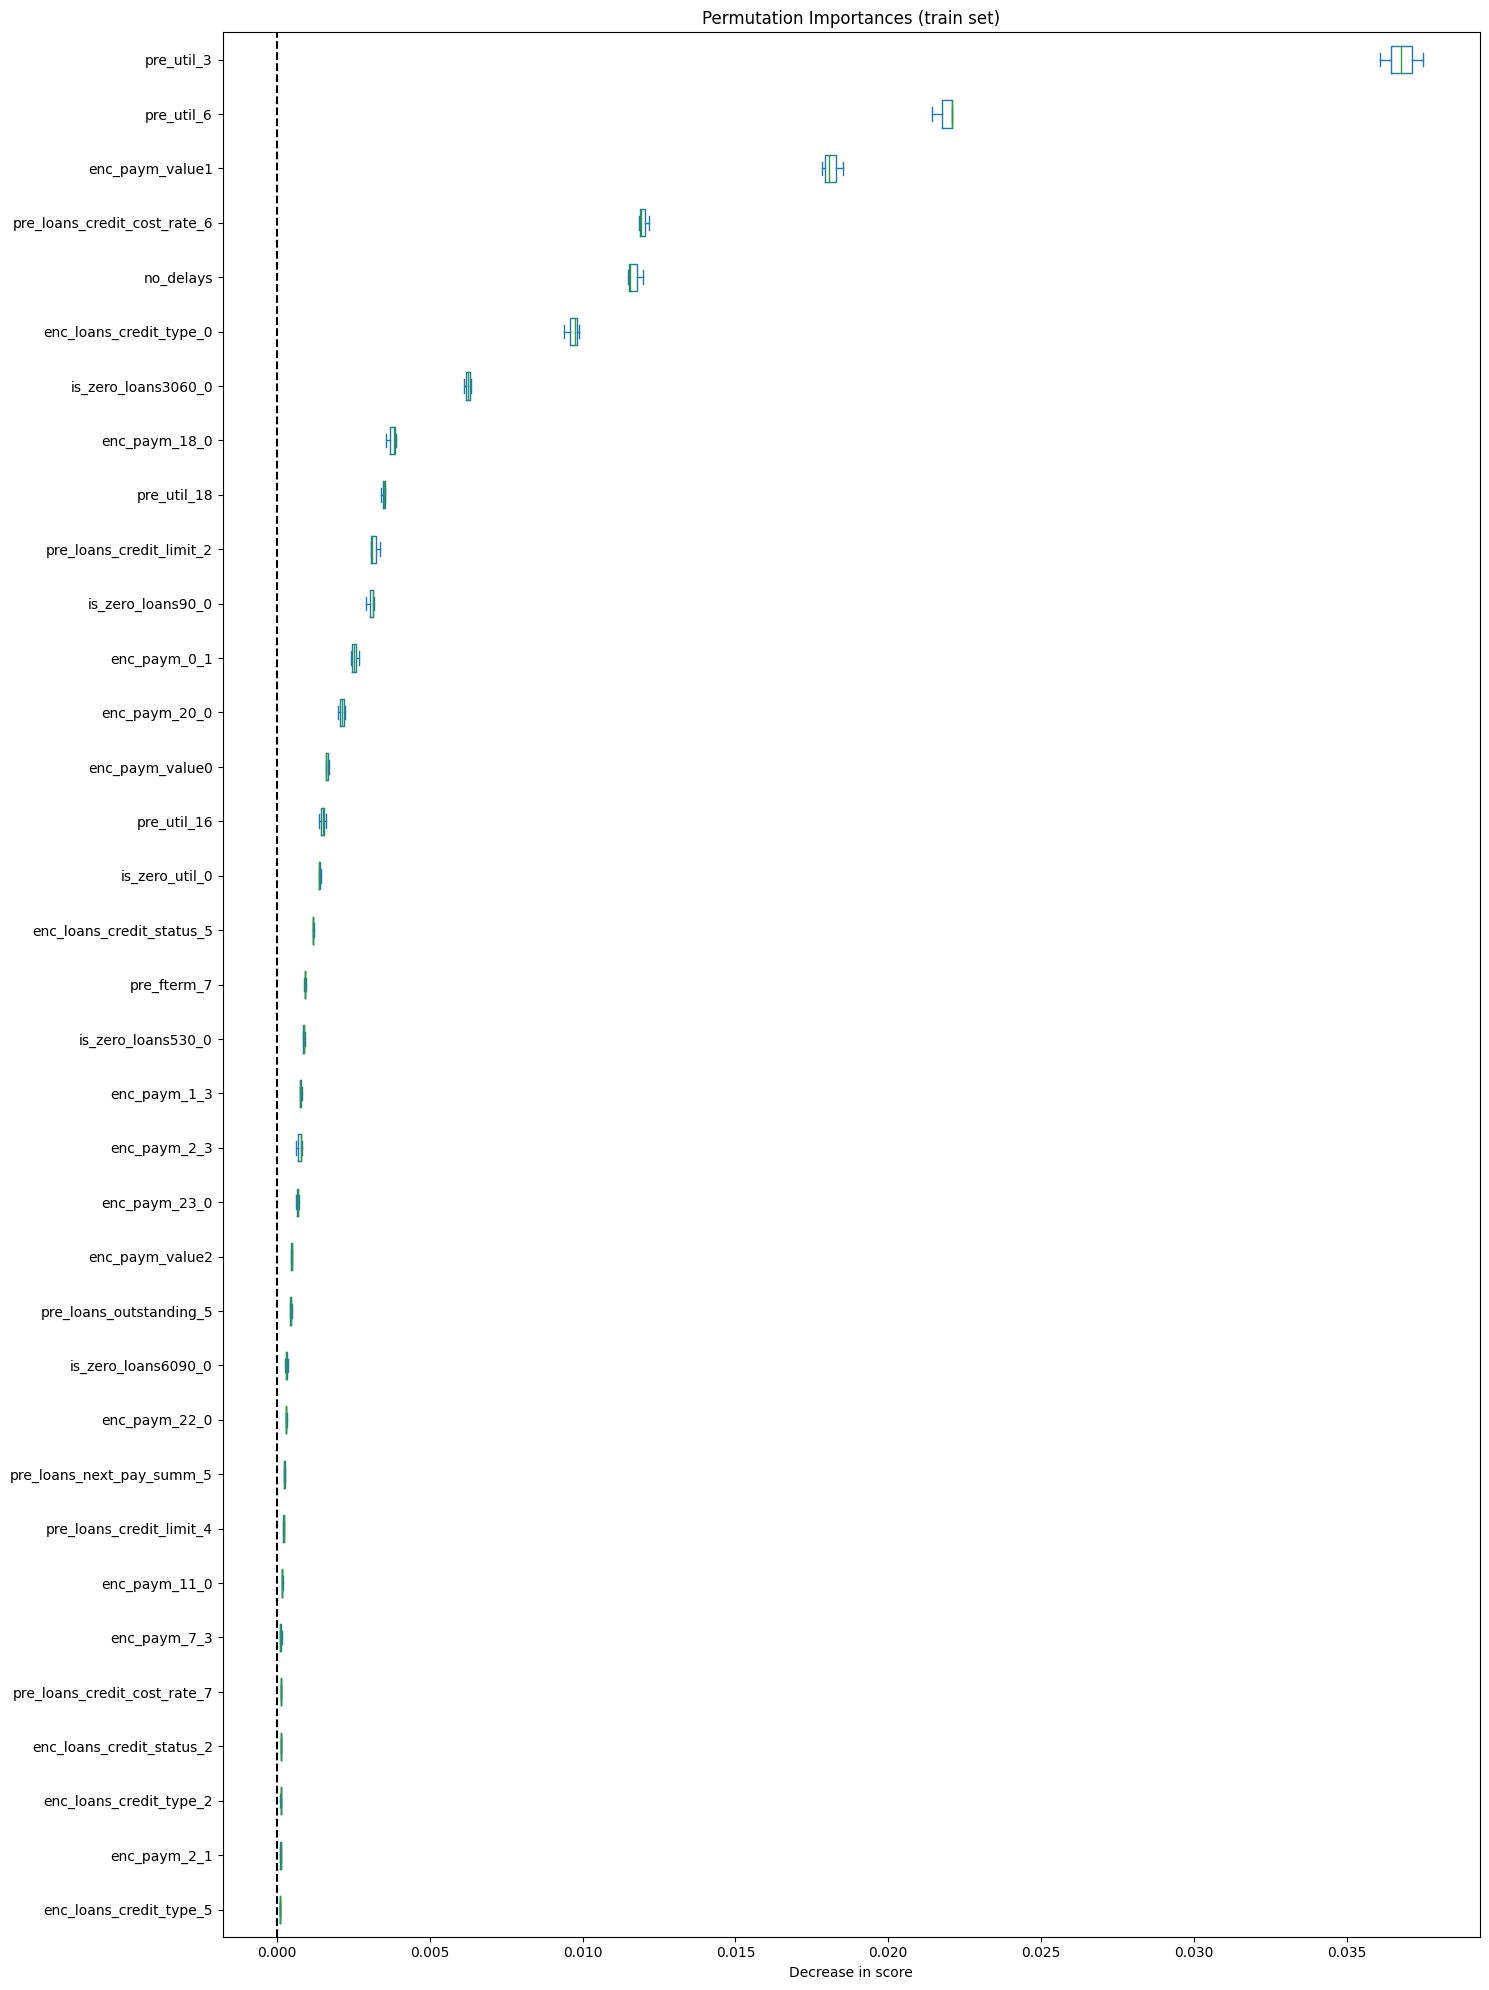

In [18]:
grad_imp = plot_importances(result01, 0.0001, x_rus)


203 features of importance value < 0.0001


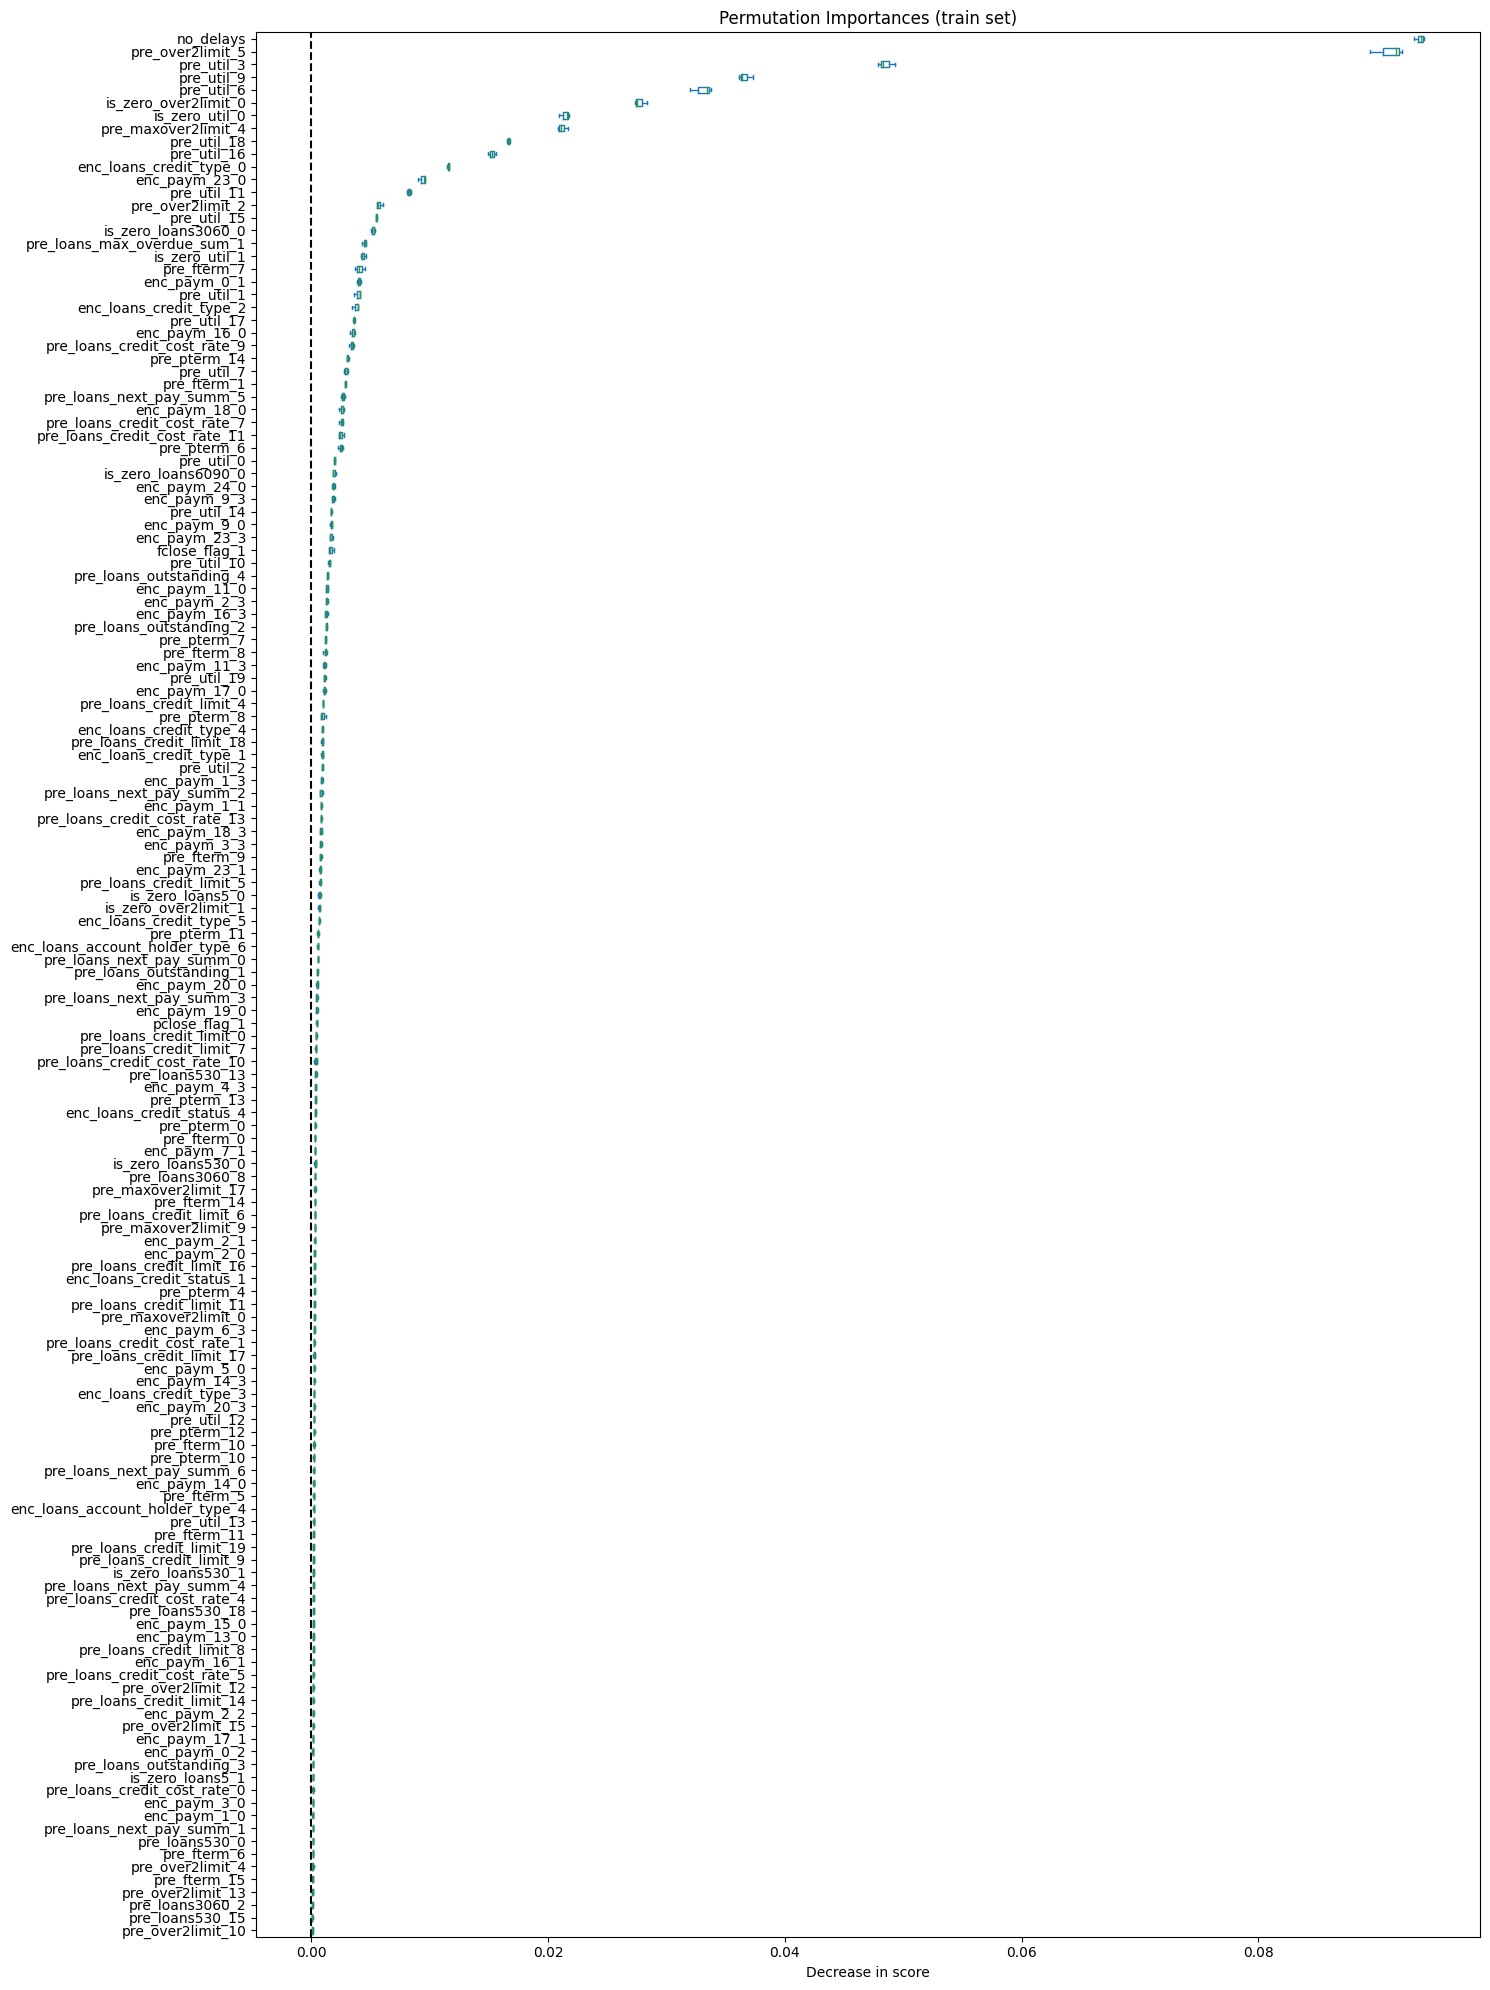

In [19]:
lr_imp  = plot_importances(result02, 0.0001, x_rus)

In [20]:
#добавленные признаки no_delays,enc_paym_valueN входят в число важных для обеих моделей, считаем, что изменение полезное
#модели работают грубо и обучались на небольших данных, поэтому отбросим только те признаки, которые оказались неважными для обеих моделей
#добавим средневзвешенные значения для тризнаков, которые оказались значимыми 
#1 вариант - можно добавить пересечение - значимые для обеих моделей, 2 вариант - все, значимые для градиентного бустинга. 
#Пойдем по второму   )

In [21]:
zero_features = list(set(set(grad_imp[0])&set(lr_imp[0])))
len(zero_features), zero_features

(192,
 ['pre_maxover2limit_6',
  'enc_paym_8_0',
  'enc_paym_12_1',
  'enc_paym_4_2',
  'enc_paym_17_3',
  'pre_over2limit_19',
  'enc_paym_9_2',
  'pre_maxover2limit_15',
  'pre_over2limit_16',
  'pre_loans530_8',
  'pre_over2limit_6',
  'enc_loans_credit_type_6',
  'is_zero_loans6090_1',
  'pre_over2limit_17',
  'pre_maxover2limit_11',
  'enc_paym_3_2',
  'pre_util_8',
  'enc_paym_21_3',
  'pre_loans6090_2',
  'enc_paym_23_2',
  'pre_loans5_7',
  'pre_loans530_2',
  'pre_fterm_12',
  'pre_loans3060_7',
  'pre_loans_credit_limit_1',
  'enc_loans_account_cur_0',
  'pre_loans5_11',
  'pre_over2limit_18',
  'pre_pterm_9',
  'pre_loans530_10',
  'enc_paym_22_3',
  'pre_maxover2limit_8',
  'enc_paym_11_1',
  'pre_over2limit_7',
  'pre_maxover2limit_1',
  'pre_pterm_2',
  'pre_loans5_16',
  'enc_paym_20_1',
  'pre_over2limit_3',
  'enc_paym_12_0',
  'enc_loans_account_cur_3',
  'enc_paym_5_3',
  'pre_loans530_19',
  'pre_loans6090_3',
  'pre_loans530_11',
  'enc_paym_13_2',
  'pre_loans5_9'

In [22]:
#in case we need to reproduce 
zero_features = ['enc_loans_account_holder_type_5',
  'pre_loans530_19',
  'enc_paym_19_1',
  'pre_maxover2limit_3',
  'pre_maxover2limit_6',
  'enc_paym_16_2',
  'pre_pterm_1',
  'enc_paym_12_1',
  'pre_loans530_11',
  'pre_loans6090_3',
  'enc_paym_8_2',
  'pre_pterm_17',
  'enc_paym_10_3',
  'enc_paym_13_3',
  'enc_paym_11_1',
  'pre_loans90_14',
  'enc_paym_15_3',
  'pre_loans5_8',
  'enc_paym_11_2',
  'enc_paym_21_3',
  'enc_paym_8_3',
  'pre_fterm_12',
  'enc_paym_24_3',
  'enc_paym_10_1',
  'pre_fterm_4',
  'enc_paym_18_1',
  'pre_pterm_2',
  'pre_loans5_0',
  'pre_loans6090_0',
  'enc_paym_4_2',
  'enc_paym_14_2',
  'pre_maxover2limit_8',
  'enc_paym_17_2',
  'enc_paym_21_1',
  'is_zero_loans6090_1',
  'enc_loans_account_cur_3',
  'pre_over2limit_1',
  'enc_paym_6_0',
  'enc_paym_7_3',
  'pre_loans90_19',
  'enc_paym_12_2',
  'pre_loans530_17',
  'pre_over2limit_8',
  'pre_loans_credit_limit_3',
  'pre_loans5_1',
  'pre_over2limit_0',
  'enc_paym_5_1',
  'enc_paym_9_1',
  'pre_loans530_6',
  'is_zero_maxover2limit_1',
  'pre_loans_credit_cost_rate_12',
  'is_zero_loans3060_1',
  'pre_loans90_10',
  'pre_maxover2limit_5',
  'pre_over2limit_9',
  'pre_pterm_9',
  'enc_paym_19_3',
  'pre_over2limit_3',
  'pre_loans_credit_cost_rate_2',
  'pre_loans90_8',
  'pre_loans_credit_cost_rate_8',
  'enc_paym_6_2',
  'pre_over2limit_11',
  'enc_loans_credit_status_6',
  'pre_pterm_3',
  'pre_loans_credit_limit_10',
  'pre_maxover2limit_14',
  'enc_paym_3_2',
  'enc_paym_8_1',
  'enc_paym_14_1',
  'pre_util_8',
  'pre_maxover2limit_16',
  'pre_loans6090_2',
  'pre_fterm_2',
  'pre_maxover2limit_10',
  'pre_maxover2limit_7',
  'pre_over2limit_17',
  'pre_over2limit_16',
  'pre_loans3060_6',
  'pre_loans5_6',
  'pre_loans6090_4',
  'pre_loans90_13',
  'pre_pterm_5',
  'pre_loans3060_1',
  'enc_loans_account_cur_2',
  'enc_paym_9_2',
  'enc_paym_10_2',
  'pre_over2limit_6',
  'pre_loans_credit_limit_13',
  'pre_loans530_7',
  'pre_loans5_9',
  'pre_loans3060_5',
  'pre_loans90_3',
  'fclose_flag_0',
  'enc_paym_4_0',
  'pre_loans3060_4',
  'pre_loans_max_overdue_sum_2',
  'pre_loans530_8',
  'pre_maxover2limit_12',
  'enc_paym_12_0',
  'enc_paym_20_2',
  'enc_loans_account_holder_type_3',
  'enc_loans_account_holder_type_1',
  'enc_paym_24_2',
  'pre_loans3060_3',
  'pre_loans5_10',
  'enc_loans_credit_type_6',
  'pre_pterm_16',
  'pclose_flag_0',
  'pre_maxover2limit_2',
  'pre_loans6090_1',
  'pre_loans530_12',
  'pre_fterm_13',
  'enc_paym_7_0',
  'enc_loans_account_cur_1',
  'pre_loans530_3',
  'pre_maxover2limit_1',
  'pre_over2limit_7',
  'is_zero_maxover2limit_0',
  'pre_loans530_4',
  'enc_paym_21_2',
  'pre_loans90_2',
  'enc_paym_4_1',
  'enc_paym_17_3',
  'pre_loans_credit_limit_12',
  'pre_loans530_5',
  'pre_pterm_15',
  'enc_paym_5_3',
  'enc_paym_20_1',
  'pre_loans530_16',
  'pre_loans_max_overdue_sum_0',
  'enc_paym_1_2',
  'pre_over2limit_19',
  'pre_maxover2limit_18',
  'enc_loans_credit_status_3',
  'enc_paym_3_1',
  'pre_over2limit_18',
  'pre_loans5_11',
  'enc_paym_15_2',
  'enc_paym_10_0',
  'pre_loans_credit_limit_15',
  'pre_loans5_7',
  'pre_maxover2limit_11',
  'enc_loans_credit_type_7',
  'enc_loans_account_holder_type_2',
  'pre_loans5_5',
  'pre_loans3060_7',
  'pre_util_5',
  'pre_loans5_3',
  'enc_paym_13_2',
  'pre_loans530_9',
  'enc_paym_8_0',
  'pre_maxover2limit_19',
  'enc_paym_5_2',
  'pre_loans_credit_limit_1',
  'pre_fterm_16',
  'pre_loans5_2',
  'enc_paym_18_2',
  'pre_maxover2limit_15',
  'is_zero_loans90_1',
  'enc_paym_19_2',
  'pre_loans_max_overdue_sum_3',
  'pre_loans530_1',
  'pre_loans3060_9',
  'pre_loans3060_0',
  'enc_paym_23_2',
  'pre_over2limit_14',
  'enc_paym_22_3',
  'enc_paym_7_2',
  'pre_loans5_16',
  'enc_paym_0_0',
  'enc_paym_6_1',
  'enc_paym_0_3',
  'enc_paym_22_1',
  'pre_maxover2limit_13',
  'enc_loans_account_cur_0',
  'pre_loans530_14',
  'enc_loans_credit_status_0',
  'pre_util_4',
  'pre_loans5_13',
  'enc_paym_13_1',
  'pre_loans530_10',
  'pre_loans_credit_cost_rate_3',
  'pre_loans530_2',
  'enc_loans_account_holder_type_0',
  'enc_paym_22_2',
  'rn',
  'enc_paym_24_1',
  'enc_paym_15_1']

In [23]:
with open('/kaggle/working/zero_features_it1.txt', 'w') as file:
     file.writelines(f"{item}\n" for item in zero_features)
    

In [24]:
relevant_features = list(grad_imp[1])
len(relevant_features), relevant_features

(35,
 ['enc_loans_credit_type_5',
  'enc_paym_2_1',
  'enc_loans_credit_type_2',
  'enc_loans_credit_status_2',
  'pre_loans_credit_cost_rate_7',
  'enc_paym_7_3',
  'enc_paym_11_0',
  'pre_loans_credit_limit_4',
  'pre_loans_next_pay_summ_5',
  'enc_paym_22_0',
  'is_zero_loans6090_0',
  'pre_loans_outstanding_5',
  'enc_paym_value2',
  'enc_paym_23_0',
  'enc_paym_2_3',
  'enc_paym_1_3',
  'is_zero_loans530_0',
  'pre_fterm_7',
  'enc_loans_credit_status_5',
  'is_zero_util_0',
  'pre_util_16',
  'enc_paym_value0',
  'enc_paym_20_0',
  'enc_paym_0_1',
  'is_zero_loans90_0',
  'pre_loans_credit_limit_2',
  'pre_util_18',
  'enc_paym_18_0',
  'is_zero_loans3060_0',
  'enc_loans_credit_type_0',
  'no_delays',
  'pre_loans_credit_cost_rate_6',
  'enc_paym_value1',
  'pre_util_6',
  'pre_util_3'])

In [25]:
def add_avg_features(data, flist):
    datanew = data.copy()
    datanew[flist] = datanew[flist].apply(lambda x: round(x/datanew['rn'], 2)).astype('float32')
    datanew = datanew[flist]
    
    datanew_cols=[str(i)+'_avg' for i in flist]
    colsdict = {i:j for i,j in zip(flist, datanew_cols)}
    datanew = datanew.rename(colsdict, axis=1)
    data =  data.join(datanew, on='id')
    gc.collect()
    return data
    
def del_zero_imp_features(data, flist):
    data = data.drop(flist, axis=1)
    
    return data



In [26]:
x_train = add_avg_features(x_train, relevant_features)
x_train.head()

,enc_paym_value0,enc_paym_value1,enc_paym_value2,enc_paym_value3,no_delays,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,...,pre_loans_credit_limit_2_avg,pre_util_18_avg,enc_paym_18_0_avg,is_zero_loans3060_0_avg,enc_loans_credit_type_0_avg,no_delays_avg,pre_loans_credit_cost_rate_6_avg,enc_paym_value1_avg,pre_util_6_avg,pre_util_3_avg
id,,,,,,,,,,,,,,,,,,,,,
1869802,66,6,0,95,3,1,1,0,0,0,...,0.00,0.0,0.33,0.00,0.00,0.50,0.0,1.00,0.0,0.00
2614361,191,11,5,163,11,0,1,4,2,0,...,0.07,0.0,0.36,0.14,0.07,0.79,0.0,0.79,0.0,0.07
422446,20,5,0,18,1,0,0,0,1,0,...,0.00,0.0,0.00,0.00,0.00,0.50,0.0,2.50,0.0,0.00
2159900,81,7,0,111,8,0,1,3,0,0,...,0.00,0.0,0.00,0.00,0.00,0.80,0.0,0.70,0.0,0.00
2414465,93,0,0,33,6,0,0,0,1,1,...,0.17,0.0,0.50,0.00,0.00,1.00,0.0,0.00,0.0,0.00


In [27]:
x_train = del_zero_imp_features(x_train, zero_features)

In [28]:
x_train.head()

,enc_paym_value0,enc_paym_value1,enc_paym_value2,enc_paym_value3,no_delays,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,...,pre_loans_credit_limit_2_avg,pre_util_18_avg,enc_paym_18_0_avg,is_zero_loans3060_0_avg,enc_loans_credit_type_0_avg,no_delays_avg,pre_loans_credit_cost_rate_6_avg,enc_paym_value1_avg,pre_util_6_avg,pre_util_3_avg
id,,,,,,,,,,,,,,,,,,,,,
1869802,66,6,0,95,3,1,1,0,0,0,...,0.00,0.0,0.33,0.00,0.00,0.50,0.0,1.00,0.0,0.00
2614361,191,11,5,163,11,0,1,0,1,0,...,0.07,0.0,0.36,0.14,0.07,0.79,0.0,0.79,0.0,0.07
422446,20,5,0,18,1,0,0,0,0,0,...,0.00,0.0,0.00,0.00,0.00,0.50,0.0,2.50,0.0,0.00
2159900,81,7,0,111,8,0,1,0,2,0,...,0.00,0.0,0.00,0.00,0.00,0.80,0.0,0.70,0.0,0.00
2414465,93,0,0,33,6,0,0,1,1,0,...,0.17,0.0,0.50,0.00,0.00,1.00,0.0,0.00,0.0,0.00


In [29]:
#Повторим качание на новом наборе признаков, чтобы убрать бесполезные

rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

scaler =  StandardScaler()
x_rus_scaled = scaler.fit_transform(x_rus)


In [30]:
grad11 = HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc', learning_rate = 0.01)
grad11.fit(x_rus, y_rus)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.01,
                               scoring='roc_auc')

In [31]:
logreg11 = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg11.fit(x_rus_scaled, y_rus)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [32]:
result11 = permutation_importance(grad11, x_rus, y_rus, n_repeats=3, random_state=42, n_jobs=-1, scoring='roc_auc')

In [33]:
result12 = permutation_importance(logreg11, x_rus_scaled, y_rus, n_repeats=3, random_state=42, n_jobs=-1, scoring='roc_auc')

46 features of importance value < 0.0001


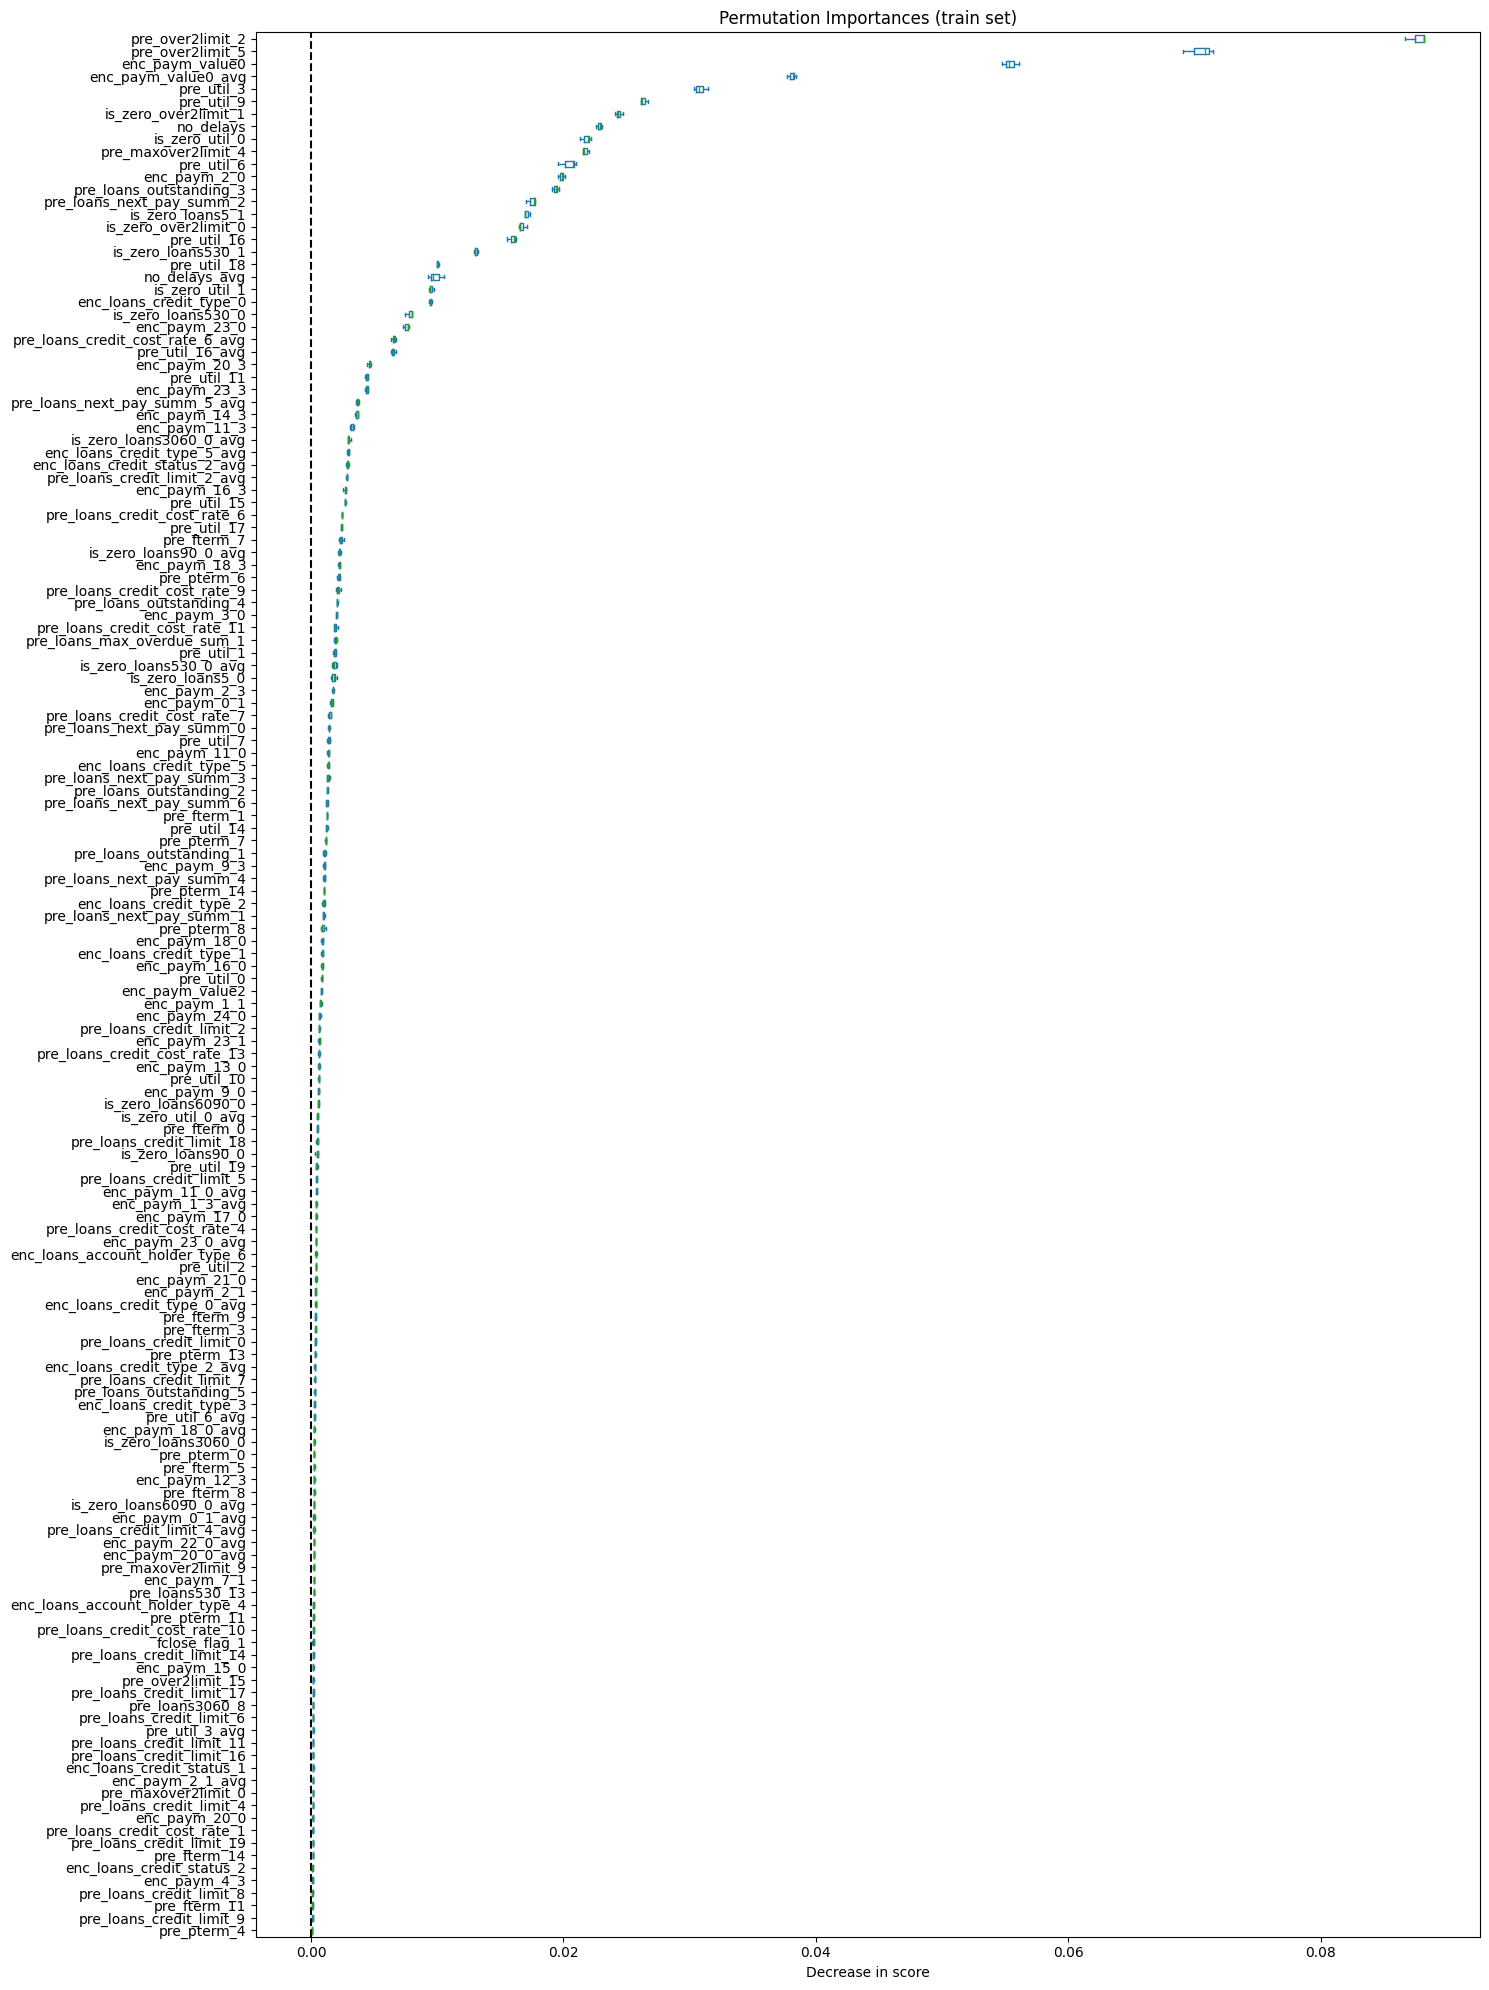

In [34]:
lr_imp2  = plot_importances(result12, 0.0001, x_rus)

158 features of importance value < 0.0001


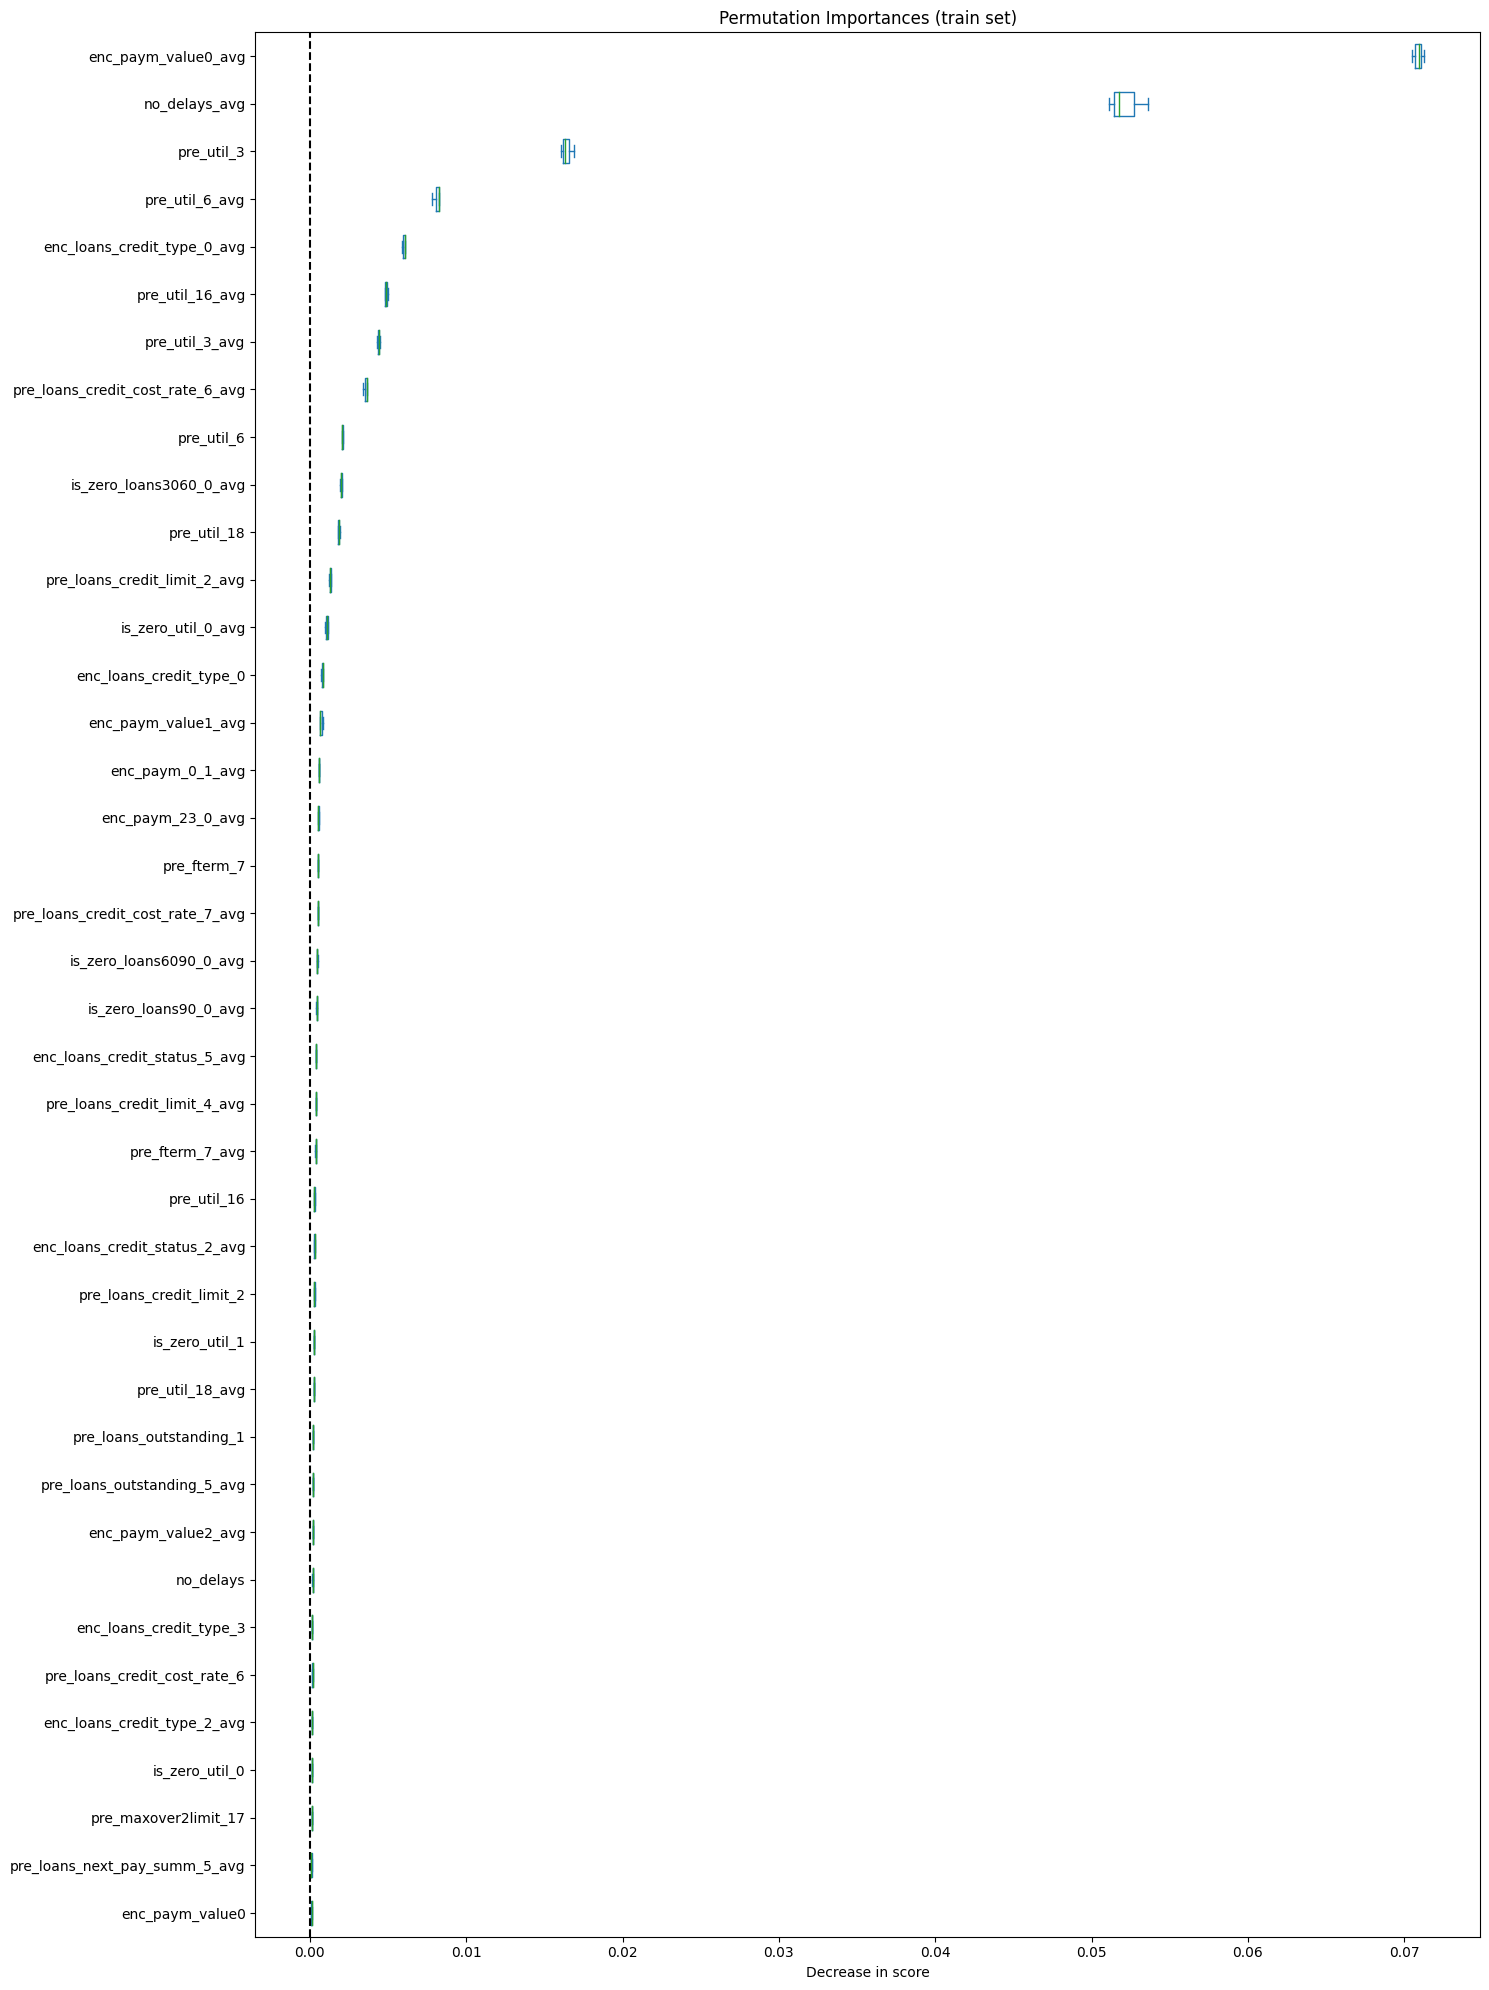

In [35]:
grad_imp2 =  plot_importances(result11, 0.0001, x_rus)

In [36]:
zero_features2 = list(set(set(grad_imp2[0])&set(lr_imp2[0])))
len(zero_features2), zero_features2

(38,
 ['enc_paym_5_0',
  'enc_paym_19_0',
  'pre_loans530_18',
  'enc_loans_credit_type_4',
  'pre_over2limit_12',
  'enc_paym_1_3',
  'pre_loans530_15',
  'pre_loans3060_2',
  'enc_paym_2_2',
  'pre_util_13',
  'pclose_flag_1',
  'pre_pterm_12',
  'pre_loans530_0',
  'pre_pterm_10',
  'enc_paym_2_3_avg',
  'enc_paym_17_1',
  'pre_util_12',
  'enc_paym_16_1',
  'pre_loans_credit_cost_rate_5',
  'enc_paym_14_0',
  'pre_fterm_6',
  'enc_loans_credit_status_5',
  'enc_paym_6_3',
  'enc_paym_7_3_avg',
  'enc_paym_0_2',
  'enc_paym_3_3',
  'enc_paym_value3',
  'enc_loans_credit_status_4',
  'pre_fterm_15',
  'enc_paym_1_0',
  'pre_over2limit_10',
  'pre_fterm_10',
  'pre_loans_next_pay_summ_5',
  'pre_over2limit_4',
  'enc_paym_22_0',
  'pre_loans_credit_cost_rate_0',
  'pre_over2limit_13',
  'enc_paym_value1'])

In [37]:
#уберем признаки,которые на втором проходе для обеих моделей оказались нерелевантными
x_train = x_train.drop(zero_features2, axis=1)

In [38]:
#проделаем то же,с тестовой частью
x_test = add_avg_features(x_test, relevant_features)
x_test = del_zero_imp_features(x_test, zero_features)


In [39]:
x_test = del_zero_imp_features(x_test, zero_features2)

In [40]:
x_train.shape, x_test.shape

((2400000, 160), (600000, 160))

In [41]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [42]:
grad = HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc')
grad.fit(x_train_scaled, y_train)

HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc')

In [43]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(x_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [44]:
def eval_classifier(model, x, y):
    probs = model.predict_proba(x) 
    probs = probs[:, 1]
    clf_auc = roc_auc_score(y, probs)
    print('ROC AUC=%.3f' % (clf_auc))
    
    print(classification_report(y, model.predict(x) ))
    
    cm = confusion_matrix(y, model.predict(x), labels=model.classes_, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    


ROC AUC=0.754
              precision    recall  f1-score   support

           0       0.98      0.66      0.79    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.66    600000
   macro avg       0.53      0.69      0.46    600000
weighted avg       0.95      0.66      0.77    600000



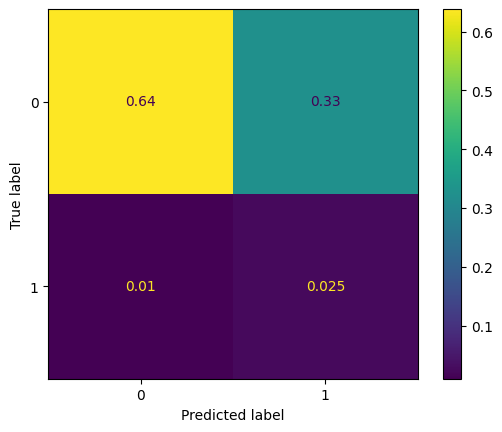

ROC AUC=0.744
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    578712
           1       0.07      0.68      0.13     21288

    accuracy                           0.69    600000
   macro avg       0.53      0.68      0.47    600000
weighted avg       0.95      0.69      0.78    600000



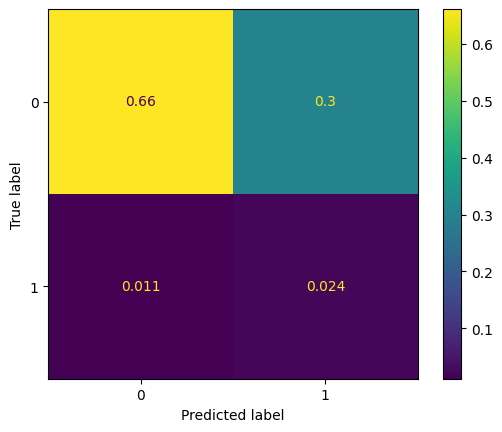

In [45]:
eval_classifier(grad, x_test_scaled, y_test)
eval_classifier(logreg, x_test_scaled, y_test)

In [46]:
#На результаты рвботы градиентного бустинга feature engineering практически не повлиял, 
#но метрика  логистической регрессии, которую планируется дальше использовать в ансамбле, подросла на 1%, к тому же мы уменьшили размерность датасета и избавились от потенциальных шумов
#на визуализации importances видно, что добавленные признаки являются значимыми для моделей, особенно для HistGradientBoostingClassifier,
#который считаем наиболее перспективной для наших целей моделью
#cчитаем проведенный feature enginering полезным и результативным


In [47]:
with open(r"/kaggle/working/zero_imp_features.txt", "w") as file:
    file.writelines(f"{item}\n" for item in zero_features)
    file.writelines(f"{item}\n" for item in zero_features2)
   
        
with open(r"/kaggle/working/relevant_features.txt", "w") as file:      
    file.writelines(f"{item}\n" for item in relevant_features)

x_train.to_parquet('/kaggle/working/x_train.parquet')
y_train.to_csv('/kaggle/working/y_train.csv', index=False)
x_test.to_parquet('/kaggle/working/x_test.parquet')
y_test.to_csv('/kaggle/working/y_test.csv', index=False)

